# Building a Text Classifier

This notebook shows how to train and evaluate a simple text classifier.

We'll make use of:
- a Twitter dataset provided by [NLTK](http://www.nltk.org/)
- the classification models provided by [Scikit-Learn](https://scikit-learn.org/stable/)

## Data preparation

Data preparation is a crucial step, you must take maximum care at this point.

There is a data mining principle saying "**trash in, trash out**". 
If you have bad data you will learn bad models.

### Downloading the Twitter dataset 

We will make use of an existing Twitter dataset available in NLTK
- Ideally we would download our own dataset using the Twitter API (http://www.nltk.org/howto/twitter.html) but that would require an API key
- So instead we will just download a sample of Twitter data that is provided by the NLTK library:

In [1]:
import nltk
nltk.download('twitter_samples')

[nltk_data] Downloading package twitter_samples to
[nltk_data]     /Users/teo/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!


True

Once the data is downloaded, have a look at it by printing out the first 20 tweets:

In [2]:
from nltk.corpus import twitter_samples
tweets = twitter_samples.strings()
tweets[:20]

['hopeless for tmr :(',
 "Everything in the kids section of IKEA is so cute. Shame I'm nearly 19 in 2 months :(",
 '@Hegelbon That heart sliding into the waste basket. :(',
 '“@ketchBurning: I hate Japanese call him "bani" :( :(”\n\nMe too',
 'Dang starting next week I have "work" :(',
 "oh god, my babies' faces :( https://t.co/9fcwGvaki0",
 '@RileyMcDonough make me smile :((',
 '@f0ggstar @stuartthull work neighbour on motors. Asked why and he said hates the updates on search :( http://t.co/XvmTUikWln',
 'why?:("@tahuodyy: sialan:( https://t.co/Hv1i0xcrL2"',
 'Athabasca glacier was there in #1948 :-( #athabasca #glacier #jasper #jaspernationalpark #alberta #explorealberta #… http://t.co/dZZdqmf7Cz',
 "I have a really good m&amp;g idea but I'm never going to meet them :(((",
 '@Rampageinthebox mare ivan :(',
 '@SophiaMascardo happy trip, keep safe. see you soon :* :(',
 "I'm so tired hahahah :(",
 '@GrumpyCockney With knee replacements they get you up &amp; about the same day. :-(   Ou

Lots of semi-coherent musings there ...

- How many tweets are there in the corpus?

In [3]:
len(tweets)

30000

### Investigating the classes

The tweets in twitter_samples are divided into 3 JSON files. The names of the files are:

In [4]:
twitter_samples.fileids()

['negative_tweets.json', 'positive_tweets.json', 'tweets.20150430-223406.json']

The first two files contain tweets judged to have negative and positive sentiment, respectively. Load tweets from the files:

In [5]:
positive_tweets = twitter_samples.strings('positive_tweets.json')
negative_tweets = twitter_samples.strings('negative_tweets.json')

How many tweets are there in each group?

In [6]:
print(f"# positive: {len(positive_tweets)}")
print(f"# negative: {len(positive_tweets)}")

# positive: 5000
# negative: 5000


Have a look at the first 10 tweets from the positive class:

In [7]:
positive_tweets[:10]

['#FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)',
 '@Lamb2ja Hey James! How odd :/ Please call our Contact Centre on 02392441234 and we will be able to assist you :) Many thanks!',
 '@DespiteOfficial we had a listen last night :) As You Bleed is an amazing track. When are you in Scotland?!',
 '@97sides CONGRATS :)',
 'yeaaaah yippppy!!!  my accnt verified rqst has succeed got a blue tick mark on my fb profile :) in 15 days',
 '@BhaktisBanter @PallaviRuhail This one is irresistible :)\n#FlipkartFashionFriday http://t.co/EbZ0L2VENM',
 "We don't like to keep our lovely customers waiting for long! We hope you enjoy! Happy Friday! - LWWF :) https://t.co/smyYriipxI",
 '@Impatientraider On second thought, there’s just not enough time for a DD :) But new shorts entering system. Sheep must be buying.',
 'Jgh , but we have to go to Bayan :D bye',
 'As an act of mischievousness, am calling the ETL layer of our in-house warehousing 

And the first 10 from the negative class:

In [8]:
negative_tweets[:10]

['hopeless for tmr :(',
 "Everything in the kids section of IKEA is so cute. Shame I'm nearly 19 in 2 months :(",
 '@Hegelbon That heart sliding into the waste basket. :(',
 '“@ketchBurning: I hate Japanese call him "bani" :( :(”\n\nMe too',
 'Dang starting next week I have "work" :(',
 "oh god, my babies' faces :( https://t.co/9fcwGvaki0",
 '@RileyMcDonough make me smile :((',
 '@f0ggstar @stuartthull work neighbour on motors. Asked why and he said hates the updates on search :( http://t.co/XvmTUikWln',
 'why?:("@tahuodyy: sialan:( https://t.co/Hv1i0xcrL2"',
 'Athabasca glacier was there in #1948 :-( #athabasca #glacier #jasper #jaspernationalpark #alberta #explorealberta #… http://t.co/dZZdqmf7Cz']

Can you guess how the tweets have been labelled? Has someone manually inspected each tweet to decide which are positive and which are negative?

### Data preprocessing

#### Finding emoticons:

Let's run a regular expression over the tweets to see what emoticons we can find in them.
- Rather than develop our regular expression, we'll use one that's been designed for the task: https://regex101.com/r/aM3cU7/4
- As you can see, it's rather long (and looks more complicated than it is).
- If we had had a list of emoticons, we could use that instead.

In [9]:
emoticon_regex = '(\:\w+\:|\<[\/\\]?3|[\(\)\\\D|\*\$][\-\^]?[\:\;\=]|[\:\;\=B8][\-\^]?[3DOPp\@\$\*\\\)\(\/\|])(?=\s|[\!\.\?]|$)'
emoticon_regex

'(\\:\\w+\\:|\\<[\\/\\]?3|[\\(\\)\\\\D|\\*\\$][\\-\\^]?[\\:\\;\\=]|[\\:\\;\\=B8][\\-\\^]?[3DOPp\\@\\$\\*\\\\)\\(\\/\\|])(?=\\s|[\\!\\.\\?]|$)'

To apply the regular expression to all the positive tweets at once:
- We'll first concatenate all of the positive tweets together into one long string separated by spaces.
- Then apply the findall() command to look for occurrences of the regular expresssion.
- That will return all the emoticon occurrences, and we'll use NLTK's Counter() to count their frequency.

In [10]:
import re 
concatenated_pos_tweets = ' '.join(positive_tweets)
emoticons_in_pos_tweets = re.findall(emoticon_regex,concatenated_pos_tweets)
counts = nltk.Counter(emoticons_in_pos_tweets)
counts

Counter({':)': 3396,
         ':-)': 657,
         ':D': 649,
         ':p': 138,
         ';3': 134,
         ';)': 21,
         ':*': 10,
         ':/': 5,
         ':-D': 5,
         ':-*': 5,
         ':3': 4,
         '83': 4,
         ';-)': 4,
         'BP': 2,
         '=D': 2,
         'BO': 2,
         'BD': 1,
         ':|': 1,
         '8p': 1,
         '8*': 1,
         ';p': 1,
         ':(': 1,
         ';*': 1,
         ':D:': 1,
         '8)': 1})

Repeat the calculation for the negative tweets (by copying and modifying the code above). 
- Are there any differences between the emoticons present in the positive and negative tweets?

In [11]:
# TODO
import re 
concatenated_neg_tweets = ' '.join(negative_tweets)
emoticons_in_neg_tweets = re.findall(emoticon_regex,concatenated_neg_tweets)
counts = nltk.Counter(emoticons_in_neg_tweets)
counts

Counter({':(': 3937,
         ':-(': 448,
         ';3': 25,
         ':/': 10,
         ':*': 5,
         ';(': 4,
         '83': 4,
         ':O': 2,
         ':3': 1,
         ':\\': 1,
         ':-*': 1,
         ':)': 1,
         '8p': 1,
         '8O': 1,
         ':-\\': 1,
         ';-)': 1,
         ':|': 1,
         '8*': 1})

#### Removing emoticons

We will shortly train a classifier to detect positive versus negative tweets. 
- Before we do that, we had better remove the emoticons from the positive and negative examples. 
- Why do we need to do that?

The code below runs over each tweet in the positive or negative set, and replaces any emoticon with an empty string:

In [12]:
positive_tweets_noemoticons = [re.sub(emoticon_regex,'',tweet) for tweet in positive_tweets]
negative_tweets_noemoticons = [re.sub(emoticon_regex,'',tweet) for tweet in negative_tweets]

Let's print out some of the tweets to check that it worked properly:

In [13]:
positive_tweets_noemoticons[:20]

['#FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week ',
 '@Lamb2ja Hey James! How odd  Please call our Contact Centre on 02392441234 and we will be able to assist you  Many thanks!',
 '@DespiteOfficial we had a listen last night  As You Bleed is an amazing track. When are you in Scotland?!',
 '@97sides CONGRATS ',
 'yeaaaah yippppy!!!  my accnt verified rqst has succeed got a blue tick mark on my fb profile  in 15 days',
 '@BhaktisBanter @PallaviRuhail This one is irresistible \n#FlipkartFashionFriday http://t.co/EbZ0L2VENM',
 "We don't like to keep our lovely customers waiting for long! We hope you enjoy! Happy Friday! - LWWF  https://t.co/smyYriipxI",
 '@Impatientraider On second thought, there’s just not enough time for a DD  But new shorts entering system. Sheep must be buying.',
 'Jgh , but we have to go to Bayan  bye',
 'As an act of mischievousness, am calling the ETL layer of our in-house warehousing app Katamari.\n\nWel

In [14]:
negative_tweets_noemoticons[:20]

['hopeless for tmr ',
 "Everything in the kids section of IKEA is so cute. Shame I'm nearly 19 in 2 months ",
 '@Hegelbon That heart sliding into the waste basket. ',
 '“@ketchBurning: I hate Japanese call him "bani"  :(”\n\nMe too',
 'Dang starting next week I have "work" ',
 "oh god, my babies' faces  https://t.co/9fcwGvaki0",
 '@RileyMcDonough make me smile :((',
 '@f0ggstar @stuartthull work neighbour on motors. Asked why and he said hates the updates on search  http://t.co/XvmTUikWln',
 'why?:("@tahuodyy: sialan https://t.co/Hv1i0xcrL2"',
 'Athabasca glacier was there in #1948  #athabasca #glacier #jasper #jaspernationalpark #alberta #explorealberta #… http://t.co/dZZdqmf7Cz',
 "I have a really good m&amp;g idea but I'm never going to meet them :(((",
 '@Rampageinthebox mare ivan ',
 '@SophiaMascardo happy trip, keep safe. see you soon  ',
 "I'm so tired hahahah ",
 '@GrumpyCockney With knee replacements they get you up &amp; about the same day.    Ouch.',
 'relate to the "sweet n

### Preparing the dataset

Before we can train a sentiment classifier, we need to format the dataset appropriately, merging the positive and negative examples into a single list:
- We can do this using the '+' operator in Python: [1,2,3]+[4,5,6] => [1,2,3,4,5,6]
- We call the combined list 'tweets_x' (since 'x' is often used to denote the input to a classifier)

In [15]:
tweets_x = positive_tweets_noemoticons + negative_tweets_noemoticons
print(tweets_x)

['#FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week ', '@Lamb2ja Hey James! How odd  Please call our Contact Centre on 02392441234 and we will be able to assist you  Many thanks!', '@DespiteOfficial we had a listen last night  As You Bleed is an amazing track. When are you in Scotland?!', '@97sides CONGRATS ', 'yeaaaah yippppy!!!  my accnt verified rqst has succeed got a blue tick mark on my fb profile  in 15 days', '@BhaktisBanter @PallaviRuhail This one is irresistible \n#FlipkartFashionFriday http://t.co/EbZ0L2VENM', "We don't like to keep our lovely customers waiting for long! We hope you enjoy! Happy Friday! - LWWF  https://t.co/smyYriipxI", '@Impatientraider On second thought, there’s just not enough time for a DD  But new shorts entering system. Sheep must be buying.', 'Jgh , but we have to go to Bayan  bye', 'As an act of mischievousness, am calling the ETL layer of our in-house warehousing app Katamari.\n\nWell… as the

We also need to make a list of class labels (the target variable that the classifier should learn to predict).
- That can be done using the '\*' operator in Python to repeat elements in a list: [1]\*5 = [1,1,1,1,1]
- We'll call the target variable: tweets_y (since 'y' is often used to denote the output of a classifier)

In [16]:
tweets_y = ['positive'] * len(positive_tweets) + ['negative'] * len(negative_tweets)
print(tweets_y)

['positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'po

#### Dividing the data into training and test sets

In order to train a classifier we need to provide it with training data. The more data the better a classification model we will learn.
- We could provide **all** the data we have to the learner, but then when we evaluate the model, we would record performance that is **too high** (better than expected on future data), because the model is being evaluated on data it has already seen during training.
- So before training the model we first divide the available data into a training set and a (hold-out) test set. 

We'll use 80% of the data to train the model and keep 20% of the data to evaluate it.
- Note that the default behaviour of sklearn's train_test_split() routine is to shuffle the data before assigning it to the training and test sets.

In [17]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(tweets_x, tweets_y, test_size=0.2, random_state=2307)

NOTE: I used a random seed to make this split reproducible (the `random_state` parameter)

#### Converting text into feature vectors

We need to **convert the text data into a vector of feature values** that can be given to a classifier. There are many different ways to do this. If training data is scarce one might look to compute hand-crafted features, such as: 
- *syntax based features*, such as the number of capitalised words in the text, 
- *part-of-speech based features*, such as the number of verbs versus the number of proper nouns, etc., or 
- *reading difficulty based features*, like the average length of words/sentences, the amount of punctuation used, etc.

But by far the **most common features** to extract from the text aree simply the *frequencies of the words* themselves. The vocabulary present in a document provides a very strong signal about the meaning of the document and thus the category it should belong to:
- One can represent documents (especially short ones like Tweets) as binary vectors (i.e. by their vocabulary). 
- But the number of times each word occcurs in the document provides further information about its meaning, so we normally represent documents as vectors of word counts. This is known as a **'bag-of-words'** representation of a document.

We can extract such a representation automatically using the CountVectorizer object from sklearn. 
- We first 'fit' the vectorizer on the training data. During this phase, sklearn determines what the vocabulary of the collection of documents is, so that it knows how many dimensions each feature vector must contain (and what word each dimension corresponds to)
- Once the vectorizer has been fit to the training set, we can go back to the training data, applying the vectorizer to generate the bag-of-words representation for each document.

Let's fit the vectorizer:

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(train_x)

CountVectorizer()

The output lists all the parameters with which the vectorizer object was instanciated. We'll talk about many of these parameters shortly, but for the moment, note the following: 
- We are not currently removing any stopwords
- A regular expression, called *token_pattern*, is used to extract the tokens from the text: **'(?u)\\b\\w\\w+\\b'**
  - (?u) says the pattern accepts unicode characters, so characters like ü should work (https://docs.python.org/2/library/re.html#re.U)
  - \\w\\w+ says the pattern is looking for 2 or more consecutive word characters 
  - \\b is a special character denoting word boundaries, so only full words will be returned (i.e. '\\bat\\b' only matches the word 'at' and not 'cat', https://www.regular-expressions.info/wordboundaries.html)

The vectorizer refers to each vocabulary element as a 'feature'. The number of features is:  

In [19]:
len(vectorizer.get_feature_names_out())

17656

That looks big, but is actually quite normal for a vocabulary. 
- Adults tend to have a vocabulary of at least 20,000 terms (see https://www.economist.com/johnson/2013/05/29/lexical-facts), and in NLP applications, vocabularies of 100,000+ are usual. 

Since we don't have that much training data (only 4,000 instances of each class), such a large vocabulary could possibly be an issue, however. 
- Let's have a look at the first 1000 terms in the vocabulary.

In [20]:
vectorizer.get_feature_names_out()[:1000]

array(['00', '000', '001', '00128835', '009', '00am', '00kouhey00',
       '00yckce7wj', '01282', '0129anne', '02079', '02392441234',
       '025wcvvnxe', '0272', '02am', '03', '0345', '0388', '0430alexu',
       '044hfi99rc', '05', '07', '08', '0878', '089624641747',
       '09gusumrnb', '0bcva6yjwu', '0founk2onj', '0frd6bgkje',
       '0l6lmn7j45', '0osbykav77', '0q92ypovkq', '0rjsclzghr',
       '0rznnslxq9', '0s8gqyoeus', '0um6xgpsan', '0uvprqnvgl',
       '0xswksxs2t', '0y142sp2ng', '0yeacg6r5p', '0ywj3efsjg',
       '0zm3zokkm6', '0zr3vlb5kl', '10', '100', '1000', '100k',
       '100reasonstovisitmombasa', '101', '1010hoshi1010', '1017nelle',
       '1031genfmsby', '1033', '1057darwin', '1093', '10am', '10th', '11',
       '110', '1100d', '111', '1111', '1190', '11am', '11h', '11s', '12',
       '120', '12000', '120nsfcs8b', '121st', '123greetingscom', '1277',
       '12pm', '12th', '13', '130', '132', '13am', '13m', '13mesh',
       '13n3wlawmq', '13th', '14', '1400', '144p', '1

### Limiting the Vocabulary


There seem to be a large number of unusual/rare words in there (although we are looking at the start of the list).
- We could reduce the vocabulary to include *only the most frequent terms* across the collection. 
- Or we could limit the vocabulary to include *only words that occur in at least a certain number of documents*. 

Both of these changes can be implemented by passing parameters to the CountVectorizer() method: 
- the first requires setting a value for **max_features** 
- the second a value for **min_df** (here 'df' stands for 'document frequency' = # of documents that the word appears in across the collection) 

If a word occurs in only a few documents across the training set, we won't have seen enough evidence to associate its presence with one of the classes. So let's try to reduce the vocabulary by requiring that each word appears in at least 5 documents. We'll also make use of an english stopword list to get rid of the highly frequent words that are unlikely to provide much useful information about the class:


In [21]:
vectorizer = CountVectorizer(min_df=5, stop_words='english')
vectorizer.fit(train_x)
print(f"vocabulary size: {len(vectorizer.get_feature_names_out())}")

vocabulary size: 1341


Wow, that significantly reduced the size of the vocabulary!

Now if we print out the vocabulary again:

In [22]:
print(*vectorizer.get_feature_names_out())

000 07 10 100 11 12 15 16 17 20 2015 24 25 2nd 30 300 33 3rd 40 452b 50 5am 5sos 969horan696 able absolutely abt acc account accounts act active actually add added address adeccowaytowork advice af afford afternoon ago agree ah ahead ahh ain aint air airport al album alex allah allowed alot alright amateur amazing amazon amber amp android ang angelhairhes angry anniversary annoying answer anybody anymore anytime apart apink app apparently apple apply appreciate appreciated aqui area aren arrived art article asap asian ask asked asking asleep ass ate august australia available aw awake away awesome awful aww awww awwww babe baby bad badly bae bag bajrangibhaijaanhighestweek1 ball bam bank barely barsandmelody bath bb bby bc bday beach beat beautiful beauty bed beli believe best bestfriend bet better bff bhaktisbanter bi0 big biggest bio birthday bit bitch black blessed blocked blog blood blue board body boo book booked books bored boring bought box boy boyfriend boys brain braindots bra

We see that it has far fewer rare words in it.
- Note: information has been lost by removing the rare words, so the best setting for what vocabulary to use for a classfication problem should be determined empirically. (More on that later.)

Now that we have established what the feature representation will be, 
- we can generate the bag-of-words/vector representation for each document in the training data, by simply calling the transform() method: 

In [23]:
train_x_vector = vectorizer.transform(train_x)
train_x_vector

<8000x1341 sparse matrix of type '<class 'numpy.int64'>'
	with 27695 stored elements in Compressed Sparse Row format>

The output tells us that: 
- We now have a matrix of 8000 training examples, where each instance is a vector of length the size of the vocabulary. 
- The information is stored as a 'sparse matrix', which is a memory efficient data structure for holding matrices where most values are zero. The matrix is sparse because most documents only contain a very small vocabulary, i.e. the count for almost all vocabulary terms in each document is zero. (In fact, the number of non zero elements in the entire matrix is only arond 27k.)
- The sparse format is critical if we have a large document collection (and/or a large vocabulary) in order to prevent the system from needlessly running out of memory. 

Let's have a look at the vector representation of a random tweet from the collection. 
- Run the following code a few times until you find an interesting tweet:

In [24]:
import random
i = random.randrange(len(train_x))

print('random tweet:')
print(train_x[i])

print('\nsparse vector:')
print(train_x_vector[i])

vocab = vectorizer.get_feature_names_out()
print('\nvocabulary of tweet:')
[(j,vocab[j]) for j in train_x_vector[i].nonzero()[1]]

random tweet:
@MercedesBenzInd The only reason I would hand it back - spare tyre in the boot.. Otherwise it was true Star 

sparse vector:
  (0, 509)	1
  (0, 935)	1
  (0, 1073)	1
  (0, 1186)	1

vocabulary of tweet:


[(509, 'hand'), (935, 'reason'), (1073, 'star'), (1186, 'true')]

## Model building

Now that our data set is ready for use, we can start training our first text classification model

### Training a classifier

Now that we have feature vectors to represent each tweet, we can finally start training a classfication model. 
- We will start with Logistic Regression, which is a work-horse of a linear classifier that reliably gives good classification performance. 
- To train the model, we simply create a model and fit it to the training data (both the instances and the class labels):

In [25]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression().fit(train_x_vector, train_y)
print(model)

LogisticRegression()


Fitting a model can sometimes take time, but for this small amount of data it is very quick. 

Printing the model didn't actually print out the model, just the arguments that LogisticRegression used when fitting it.
- These includes technical details regarding the solver used ('lbfgs') and the maximum number of iterations (100) run to fit the model. 
- The most interesting parameters for us are probably the 'C' term, which controls the amount of regularisation applied to prevent the model from overfitting the training data, and the 'penalty', which determines what type of regularisation is being performed. In this case, an 'l2' penalty has been applied. Interesting would be to try an 'l1' penalty which will try to reduce the number of features used in the model. (More on that later.)

### Making Predictions

Now that we have fit the model, we can use it to make a prediction!

Let's create some examples, transform them into feature vectors, and then use the model.predict() function to make predictions for them:

In [26]:
tweet0 = 'I can\'t believe how much fun I\'m having learning to train a text classifier!'
tweet1 = 'I am really confused. I want my mommy.'
tweet2 = 'The internet connection has been pretty annoying today!'
tweet3 = 'They just played my favourite song on the radio.'
tweet4 = "I don't like going to the dentist."
transformed_tweets = vectorizer.transform([tweet0,tweet1,tweet2,tweet3,tweet4])
predictions = model.predict(transformed_tweets)
print(predictions)

['positive' 'negative' 'negative' 'positive' 'negative']


Well, that seemed to work!
- Try entering some other examples and see how the model performs.

In [27]:
tweet5 = 'This classifier is working really well. I\'m happy'
tweet6 = 'I had a really bad day today'
transformed_tweets = vectorizer.transform([tweet0,tweet1,tweet2,tweet3,tweet4,tweet5,tweet6])
predictions = model.predict(transformed_tweets)
print(predictions)

['positive' 'negative' 'negative' 'positive' 'negative' 'positive'
 'negative']


As well as providing predictions, we can get the model to produce probabilities that quantify the classifier's confidence in the predicted labels:

In [28]:
predicted_probabilities = model.predict_proba(transformed_tweets)
print(predicted_probabilities)

[[0.39665185 0.60334815]
 [0.92329628 0.07670372]
 [0.847064   0.152936  ]
 [0.45807617 0.54192383]
 [0.63799821 0.36200179]
 [0.41488581 0.58511419]
 [0.70465482 0.29534518]]


The first value is the predicted probablity of the negative class, the second of the positive class.
- For which tweet is the classifier least confident of its prediction?  

## Model evaluation

### Investigating the Model

Logistic Regression is a **linear classifier**: 
- That means that it divides the feature space into two regions separated by a linear boundary (called a hyperplane). 
- It also means that the classification model consists of one parameter for each feature, and that the predictions of the model are computed by multiplying each feature value by its corresponding parameter value. 
- Thus, since all our features are merely word counts, we can investigate the importance of the different words for the prediction by inspecting the parameters of the model used. 

Let's start by printing out the parameters of the model:

In [29]:
model_params = [(vocab[j],model.coef_[0][j]) for j in range(len(vocab))]
model_params

[('000', 0.9715050474825401),
 ('07', -0.6884164072856852),
 ('10', 1.0341899083069004),
 ('100', 0.13556701651679112),
 ('11', -0.10494395582450385),
 ('12', 0.7950093898303513),
 ('15', -0.31366512859002477),
 ('16', 0.5931772016711404),
 ('17', 1.1881627592215835),
 ('20', -0.09380628738021568),
 ('2015', 0.03645256776991486),
 ('24', -0.7670023926440352),
 ('25', 0.21448328189163654),
 ('2nd', 0.01783662640898518),
 ('30', 0.1116201504464914),
 ('300', -0.06126593686970606),
 ('33', -0.5103224471392458),
 ('3rd', 0.33491744113852806),
 ('40', 0.06461126314724422),
 ('452b', 0.913734245997709),
 ('50', -0.3214569375276298),
 ('5am', -0.6940585397402778),
 ('5sos', 0.33265256627350703),
 ('969horan696', 0.4765847972888976),
 ('able', -0.7166417085312973),
 ('absolutely', 0.45057918071042447),
 ('abt', -0.18047989944489307),
 ('acc', -0.5502206697988162),
 ('account', 0.17687658787584856),
 ('accounts', -0.68708209638264),
 ('act', 0.5120865944458793),
 ('active', -0.21444252052005922

That's a big list! 
- But did you notice some of the more negative words having negative coefficients?
- Let's have a look at the 50 words with the highest negative values:


In [30]:
sorted(model_params, key=lambda x: x[1])[:50]

[('miss', -2.9744720405674023),
 ('sad', -2.5794016786954677),
 ('unfortunately', -2.239152609795274),
 ('isn', -2.1540556976536434),
 ('ugh', -2.0389066245626917),
 ('missing', -1.9922145971632708),
 ('lost', -1.9740684571451208),
 ('damn', -1.966886167767699),
 ('shame', -1.8937907223599653),
 ('zayniscomingbackonjuly26', -1.8745668267756879),
 ('poor', -1.86528916643773),
 ('tired', -1.738625465249386),
 ('idk', -1.7028746163050732),
 ('sorry', -1.6914752649259386),
 ('load', -1.65715797029354),
 ('weather', -1.6265057942157348),
 ('lonely', -1.591412460350038),
 ('wish', -1.5714833420981273),
 ('choose', -1.5653668019354592),
 ('aw', -1.5622919207751378),
 ('followed', -1.5578791111463615),
 ('anymore', -1.537888932919966),
 ('seriously', -1.5149841678254035),
 ('sick', -1.4881013713578353),
 ('missed', -1.4702365547890324),
 ('awful', -1.4510781513724471),
 ('pls', -1.4282400496558856),
 ('justinbieber', -1.4209353085355678),
 ('rafaelallmark', -1.399585801638518),
 ('fries', -1.3

And those with the highest positive coefficients:

In [31]:
sorted(model_params, key=lambda x: -x[1])[:50]

[('thank', 2.3780471259665155),
 ('fback', 2.3276572884080533),
 ('thanks', 2.2957724124809067),
 ('glad', 2.239121006967924),
 ('welcome', 2.1272769707296275),
 ('ff', 2.084046995500477),
 ('nice', 2.0038323119835177),
 ('goodnight', 1.9292801609533734),
 ('happy', 1.7887018407353106),
 ('cheers', 1.698576728964812),
 ('enjoy', 1.6369035422829397),
 ('smiling', 1.6205841082431403),
 ('great', 1.6028658958719628),
 ('follback', 1.5599080996976395),
 ('bro', 1.5428878728681883),
 ('buddy', 1.5425505347166808),
 ('views', 1.5095884396479975),
 ('excited', 1.4486030775450833),
 ('awesome', 1.4438545302908354),
 ('bajrangibhaijaanhighestweek1', 1.4391058511024468),
 ('congrats', 1.4305582609693244),
 ('cool', 1.4305454529843102),
 ('fabulous', 1.4244130824417447),
 ('definitely', 1.3820535737054898),
 ('men', 1.3722321441559409),
 ('hehe', 1.3704013477440677),
 ('main', 1.3659501334213695),
 ('fantastic', 1.3505051919352433),
 ('luck', 1.3398614063278094),
 ('worry', 1.3235860426998334),
 

It seems like the model is learning well to distinguish between words with positive and negative sentiment.  

We can also look at individual tweets to understand why the model makes the predictions it does:

In [32]:
tweet = "I don't like going to the dentist."
vectorized_tweet = vectorizer.transform([tweet])[0]
print('tweet:')
print(tweet)
print('model coefficients:')
[(j,vocab[j],model.coef_[0][j]) for j in vectorized_tweet.nonzero()[1]]

tweet:
I don't like going to the dentist.
model coefficients:


[(318, 'don', -0.6676327777639808),
 (476, 'going', 0.0822539887840571),
 (681, 'like', 0.28851289714044337)]

### Evaluating the Accuracy of the Model's Predictions

To understand how the classifier is likely to perform on average on new examples, we need to test it on a large dataset which it hasn't seen for training.
- Thankfully, we held-out 20% of our data exactly for this purpose ;-) 
- So let's now compute the predictions on that held-out data, (which we called 'test_x' with corresponding ground-truth labels 'test_y')

In [33]:
test_x_vector = vectorizer.transform(test_x)
pred_y = model.predict(test_x_vector)

The first measure to compute is accuracy, which is simply the number of times the classifier correctly predicted the actual class of the document.
- If the positive and negative classes are fairly balanced (i.e. we have around the same number of positive and negative instances in our test set) and we don't care whether we misclassify a positive as a negative or vice versa, then accuracy is the measure to use.  
- We can calculate accuracy by importing the accuracy_score() function from sklearn's metrics. The function takes both the predicted and true labels as input and returns the accuracy:

In [34]:
from sklearn.metrics import accuracy_score
print(f'accuracy: {accuracy_score(pred_y, test_y):.4f}')

accuracy: 0.7420


Well, that's not terrible -- but it's not fantastic either. 
- The model predicts the sentiment correctly **74%** of the time.
- For short and noisy documents like tweets, and where the ground-truth labels were extracted automatically from emoticons, a success rate around 3/4 is probably not too bad.
- For longer and less noisy documents, we would expect the accuracy for a binary prediction problem to be much higher -- in the nineties usually.

How could we improve performance? 
- The obvious and most reliable way to improve the performance of a text classifier is to **collect more data**. The more data the classifier has, the better the performance will be.
- The second most obvious way would be to try to collect less noisy data.
- It may be the case, however, that for this particular task, an accuracy much higher than the current value is not achievable because the sentiment of short tweets isn't that predictable.  

Let's try to understand where the model is making its errors by printing out the confusion-matrix, which for a binary classification task is simply the matrix of true positive, false negative, false positive and true positive counts (https://en.wikipedia.org/wiki/Confusion_matrix):

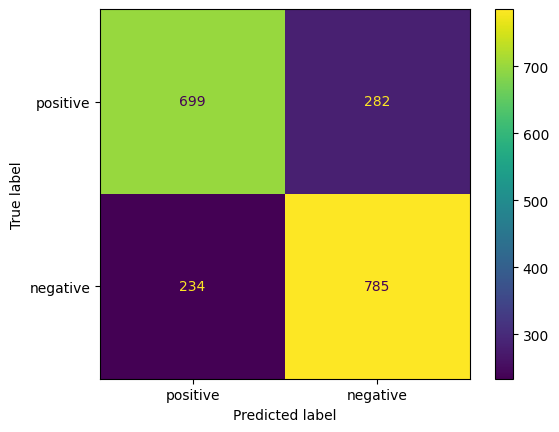

In [35]:
import matplotlib.pyplot as plt  
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(test_y, pred_y, labels=['positive', 'negative'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['positive', 'negative'])
disp.plot()
plt.show()

It looks like the model is relatively balanced, but confusing a few more positives for negatives than the other way around. 

### Precision, Recall and F-Measure

Finally, we can generate more useful metrics, such as Precision, Recall and F-measure for the two classes. What are they?
- Precision (for the positive class) is the percentage of instances predicted as positive that actually were positive
- Recall (for the positive class) is the percentage of positive instances that were predicted as positive by the model
- F-measure is a metric that combines (via the harmonic mean) the precision and recall values. We often try to optimise it

In [36]:
from sklearn.metrics import classification_report
print('\nclassification report:\n')
print(classification_report(test_y, pred_y, target_names=['positive','negative']))


classification report:

              precision    recall  f1-score   support

    positive       0.74      0.77      0.75      1019
    negative       0.75      0.71      0.73       981

    accuracy                           0.74      2000
   macro avg       0.74      0.74      0.74      2000
weighted avg       0.74      0.74      0.74      2000



### Comparing different Models on a Validation Set

There are many ways one could go about improving the quality of the classifier trained above. 
- One could change the model, its arguments, or the feature space. This process is called **model selection**.  

**Before** embarking on any of these tests, we must first further partition the training data into a training and validation set. 
- Why would we do that? Because we want to make sure we don't end up learning a model that works well on the test set, but doesn't generalise well to new data. 
- By keeping the test set for the evaluation of the final model, we know that we have not inadvertantly optimised the model on it. 

In practice, if we are working with relatively small datasets as is the case here, we would perform k-fold cross-validation rather than simply repeating hold-out for the validation set. In this case, k distinct models are trained and evaluated on partitions of the data with k-1 partitions used for training and 1 for testing on each round.

In [37]:
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.2, random_state=2307)
print(f"# train: {len(train_x)}")
print(f"# valid: {len(valid_x)}")
print(f"# test: {len(test_x)}")

# train: 6400
# valid: 1600
# test: 2000


Note: be careful to execute the cell above only once, since it replaces the input variables with new ones each time.

We could now try different linear classifiers: 
- such as MultinomialNB -- a model that is traditionally very often used with text
- a Support Vector Machine (with a linear kernel) -- a **very reliable model for high dimensional data** 
- or even a non-linear classifier, such as XGBoost

Each of these classifiers have hyperparameters that one might try to tune, such as:
- the type of regularisation (l1 versus l2) -- l1 can work well to reduce the feature set for text problems
- the parameter controlling the strength of the regularisation 

Perhaps more important than the classification model trained is the set of features used. We could to **change the feature space** by: 
- increasing or reducing the vocabulary
  - add stopwords 
  - change the maximum feature count or the min_df value
- adding **new features**
  - in particular **ngrams** are often used to improve text classifiers
  - we include bigrams pairs of consecutive words as features
- rescaling the features
  - using TF-IDF weighting scheme that is particularly useful for web search since it can sometimes help the classifier to find the appropriate value for the coefficients.


In [38]:
# TODO

Here I train an SVM classifier on the the reduced training data and check it's performance on the validation set:

In [39]:
train_x_vector = vectorizer.transform(train_x)

from sklearn.linear_model import SGDClassifier
model = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, max_iter=5, tol=None).fit(train_x_vector, train_y)

valid_x_vector = vectorizer.transform(valid_x)
pred_y = model.predict(valid_x_vector)

print('Results for the basic SVM classifier:')
print(f'accuracy: {accuracy_score(pred_y, valid_y)}')
print(classification_report(valid_y, pred_y, target_names=['positive','negative']))

Results for the basic SVM classifier:
accuracy: 0.73125
              precision    recall  f1-score   support

    positive       0.71      0.80      0.75       810
    negative       0.76      0.66      0.71       790

    accuracy                           0.73      1600
   macro avg       0.74      0.73      0.73      1600
weighted avg       0.73      0.73      0.73      1600



NOTE: the SGD classifier is a generic tool for linear classifiers, SVMs are a special case of SGD classifier using the hinge loss

Try out some other models! 
- What setting results in the best peformance? 
- What is the test accuracy in that case?

In [40]:
# TODO

For example, we could try Logistic Regression with an L1 penalty, aimed at removing features that are not useful for the classification (i.e. performing feature selection).

In [41]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(penalty='l1',solver='saga',max_iter=4000).fit(train_x_vector, train_y)
print(model)

LogisticRegression(max_iter=4000, penalty='l1', solver='saga')


The L1 penalty causes a reduction in the number of non-zero coefficients in the model. 
- This is referred to as a sparse model:

In [42]:
print(f'Number of vocabulary elements {len(vocab)}')
print(f'Number of non-zero coefficients: {sum(sum(model.coef_ != 0))}')

Number of vocabulary elements 1341
Number of non-zero coefficients: 643


The performance of the sparse model:

In [43]:
pred_y = model.predict(valid_x_vector)

print('Results for L1-regularized Logistic Regression classifier:')
print(f'accuracy: {accuracy_score(pred_y, valid_y)}')
print(classification_report(valid_y, pred_y, target_names=['positive','negative']))

Results for L1-regularized Logistic Regression classifier:
accuracy: 0.726875
              precision    recall  f1-score   support

    positive       0.71      0.78      0.74       810
    negative       0.75      0.67      0.71       790

    accuracy                           0.73      1600
   macro avg       0.73      0.73      0.73      1600
weighted avg       0.73      0.73      0.73      1600



Let's have a look at the coefficients of the sparse model
- Note all of the words deemed to not be discriminative of the class and given a coefficient of zero:
 

In [44]:
model_params = [(vocab[j],model.coef_[0][j]) for j in range(len(vocab))]
model_params

[('000', 0.0),
 ('07', 0.0),
 ('10', 0.664663686311302),
 ('100', 0.0),
 ('11', 0.0),
 ('12', 0.017602321565619774),
 ('15', 0.0),
 ('16', 0.0),
 ('17', 1.9198343968075178),
 ('20', 0.0),
 ('2015', 0.0),
 ('24', -1.6031317203858046),
 ('25', 0.0),
 ('2nd', 0.0),
 ('30', 0.0),
 ('300', 0.0),
 ('33', -0.3959379780833597),
 ('3rd', 0.0),
 ('40', 0.0),
 ('452b', 0.0),
 ('50', 0.0),
 ('5am', -0.1534789578297635),
 ('5sos', 0.0),
 ('969horan696', 0.38481067903350424),
 ('able', -0.4482529562914187),
 ('absolutely', 0.0),
 ('abt', 0.0),
 ('acc', -0.25221903355124853),
 ('account', 0.0),
 ('accounts', -0.01379678695230572),
 ('act', 0.265606606632366),
 ('active', 0.0),
 ('actually', 0.0),
 ('add', 0.0),
 ('added', 0.0),
 ('address', 0.0),
 ('adeccowaytowork', 1.1782613045408823),
 ('advice', 0.0),
 ('af', -0.35958350423703495),
 ('afford', -1.2625227775414474),
 ('afternoon', 0.269002300215046),
 ('ago', 0.0),
 ('agree', 0.0),
 ('ah', 0.0),
 ('ahead', 0.0),
 ('ahh', 0.0),
 ('ain', 0.0),
 ('ai

## Further readings

This recent blog post is worth reading. The author develops a text classifier for identifying COVID-19 missinformation: 
- https://towardsdatascience.com/automatically-detect-covid-19-misinformation-f7ceca1dc1c7